# Ringer Illustration

This notebook is used to generate the ringer illustration and reconstruction steps.

In [1]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'font.size': 50})
import numpy as np
from matplotlib.colors import LogNorm
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['legend.fontsize'] = 14
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['text.usetex'] = True
rcParams['grid.alpha'] = 0.0

xrange=range
def make_element():
    """ A element consists of a bunch of planes/surfaces..."""

    element = {
        "top"    : np.asarray( [[[0,1],[0,1]], [[0,0],[1,1]], [[1,1],[1,1]]] ),
        "bottom" : np.asarray( [[[0,1],[0,1]], [[0,0],[1,1]], [[0,0],[0,0]]] ),
        "left"   : np.asarray( [[[0,0],[0,0]], [[0,1],[0,1]], [[0,0],[1,1]]] ),
        "right"  : np.asarray( [[[1,1],[1,1]], [[0,1],[0,1]], [[0,0],[1,1]]] ),
        "front"  : np.asarray( [[[0,1],[0,1]], [[0,0],[0,0]], [[0,0],[1,1]]] ),
        "back"   : np.asarray( [[[0,1],[0,1]], [[1,1],[1,1]], [[0,0],[1,1]]] )
    }

    return element

def apply_spacing(l, m, n, spacing=(None, 0,0,0)):
    """Position of array elements in relation to each other."""

    recipe, l_f, m_f, n_f = spacing
    if recipe not in [None, 'even', 'l', 'm', 'n']:
        raise TypeError("BAD")

    if recipe is None:
        return (0,0,0)
    elif recipe == 'even':
        return (l*l_f, m*m_f, n*n_f)
    elif recipe == 'l':
        return (l*l_f, l*m_f, l*n_f)
    elif recipe == 'm':
        return (m*l_f, m*m_f, m*n_f)
    elif recipe == 'n':
        return (n*l_f, n*m_f, n*n_f)
    else:
        raise TypeError("Unknown recipe[%s]" % recipe)

def text_coords(array, l, m, n):
    return "[%d,%d,%d]" % (l, m, n)

def text_values(array, l, m, n):
    return str(array[l,m, n])

In [9]:
class NDArrayPlotter(object):

    def __init__(
        self, 
        array,
        color="blue",
        alpha="0.6",
        scale=(1, 1, 1),
        spacing=(None, 0,0,0)
    ):
        self.defaults_ = {
            "color":    color,
            "alpha":    alpha,
            "scale":    scale,
            "spacing":  spacing
        }
        self.reset(array)

    def reset(self, array):
        self.array_ = array
        self.set_color(self.defaults_["color"])
        self.set_alpha(self.defaults_["alpha"])
        self.set_spacing(self.defaults_["spacing"])
        self.set_scale(self.defaults_["scale"])

        
    def set_color(self, colors):
        #self.colors = np.zeros(self.array_.shape, dtype=('a10'))
        self.colors = colors
        return self.colors

    def set_alpha(self, alpha):
        self.alphas = np.empty(self.array_.shape, dtype=np.float32)
        self.alphas[:] = alpha
        return self.alphas

    def set_scale(self, scale):
        self.scale = scale
        return self.scale

    def set_spacing(self, spacing):
        self.spacing = spacing
        return self.spacing

    def render(self, ax, array=None, text=None, azim=-15, elev=15, a=0, b=0, c=0):
        if not array:
            array = self.array_
        if array.shape != self.array_.shape:
            reset(array)
        #fig = plt.figure(figsize=(10,10), dpi=120)
        #ax = fig.add_subplot(111, projection='3d')

        element = make_element()

        for l in xrange(0, array.shape[0]):
            for m in xrange(0, array.shape[1]):
                for n in xrange(0, array.shape[2]):

                    # Extract settings that apply to all sides of the element
                    alpha = self.alphas[l, m, n]
                    color = self.colors[l, m, n]
                    relative_pos = apply_spacing(l, m, n, self.spacing)
                    
                    for side in element:
                        (Ls, Ms, Ns) = (
                            self.scale[0]*(element[side][0] + l ) +relative_pos[0] + a,
                            self.scale[1]*(element[side][1] + m ) +relative_pos[1] + b,
                            self.scale[2]*(element[side][2] + n ) +relative_pos[2] + c
                        )
                        ax.plot_surface(
                            Ls, Ns, Ms,
                            rstride=1, cstride=1,
                            alpha=alpha,
                            color=color,
                            edgecolors=(0, 0, 0, 0.5),
                            linewidth=0.2
                        )
                    
                    if text:

                        elmt_label = text(array, l, m, n)

                        elmt_center_coord = np.asarray([l,m,n])
                        elmt_center_coord = elmt_center_coord*np.asarray(self.scale) \
                                         + np.asarray(relative_pos)
                        elmt_center_coord = elmt_center_coord + np.asarray(self.scale)/2.0
                        elmt_label_coord = elmt_center_coord
                        ax.text(
                            elmt_label_coord[0], elmt_label_coord[2], elmt_label_coord[1], 
                            elmt_label,
                            horizontalalignment='center', verticalalignment='center',
                            zdir='y'
                        )
        highest = 0               
        for size in array.shape:
            if size > highest:
                highest = size
        ax.set_xlim((0,highest))
        ax.set_ylim((0,highest))
        ax.set_zlim((0,highest))
        plt.gca().invert_zaxis()
        L, M, N = array.shape
        L_scl,  M_scl,  N_scl  = np.asarray(self.scale)
        L_skew, M_skew, N_skew = apply_spacing(L_scl, M_scl, N_scl, self.spacing)
        axis_label_format = r"$\leftarrow$ \textbf{\emph{%s}} $\rightarrow$"
        plt.axis('off')
        ax.view_init(azim=azim, elev=elev)

In [3]:
def make_rings_colors( x_center, y_center, x_size, y_size):
    colors = [[ None for _ in range(y_size)] for __ in range(x_size)]
    for x in range(x_size):
        for y in range(y_size):
            
            delta_x = abs(x - x_center)
            delta_y = abs(y - y_center)
            delta = max(delta_x, delta_y)
            #print(delta)
            if delta == 0:
                # red
                colors[x][y] = (0.96,0,0,0) 
            elif delta%2==0: 
                #write
                colors[x][y] = (0,0,0,0) 
            else:
                # black
                colors[x][y] = (1,1,1,0) 
    return colors

## Create Eletromagnetic Layers:

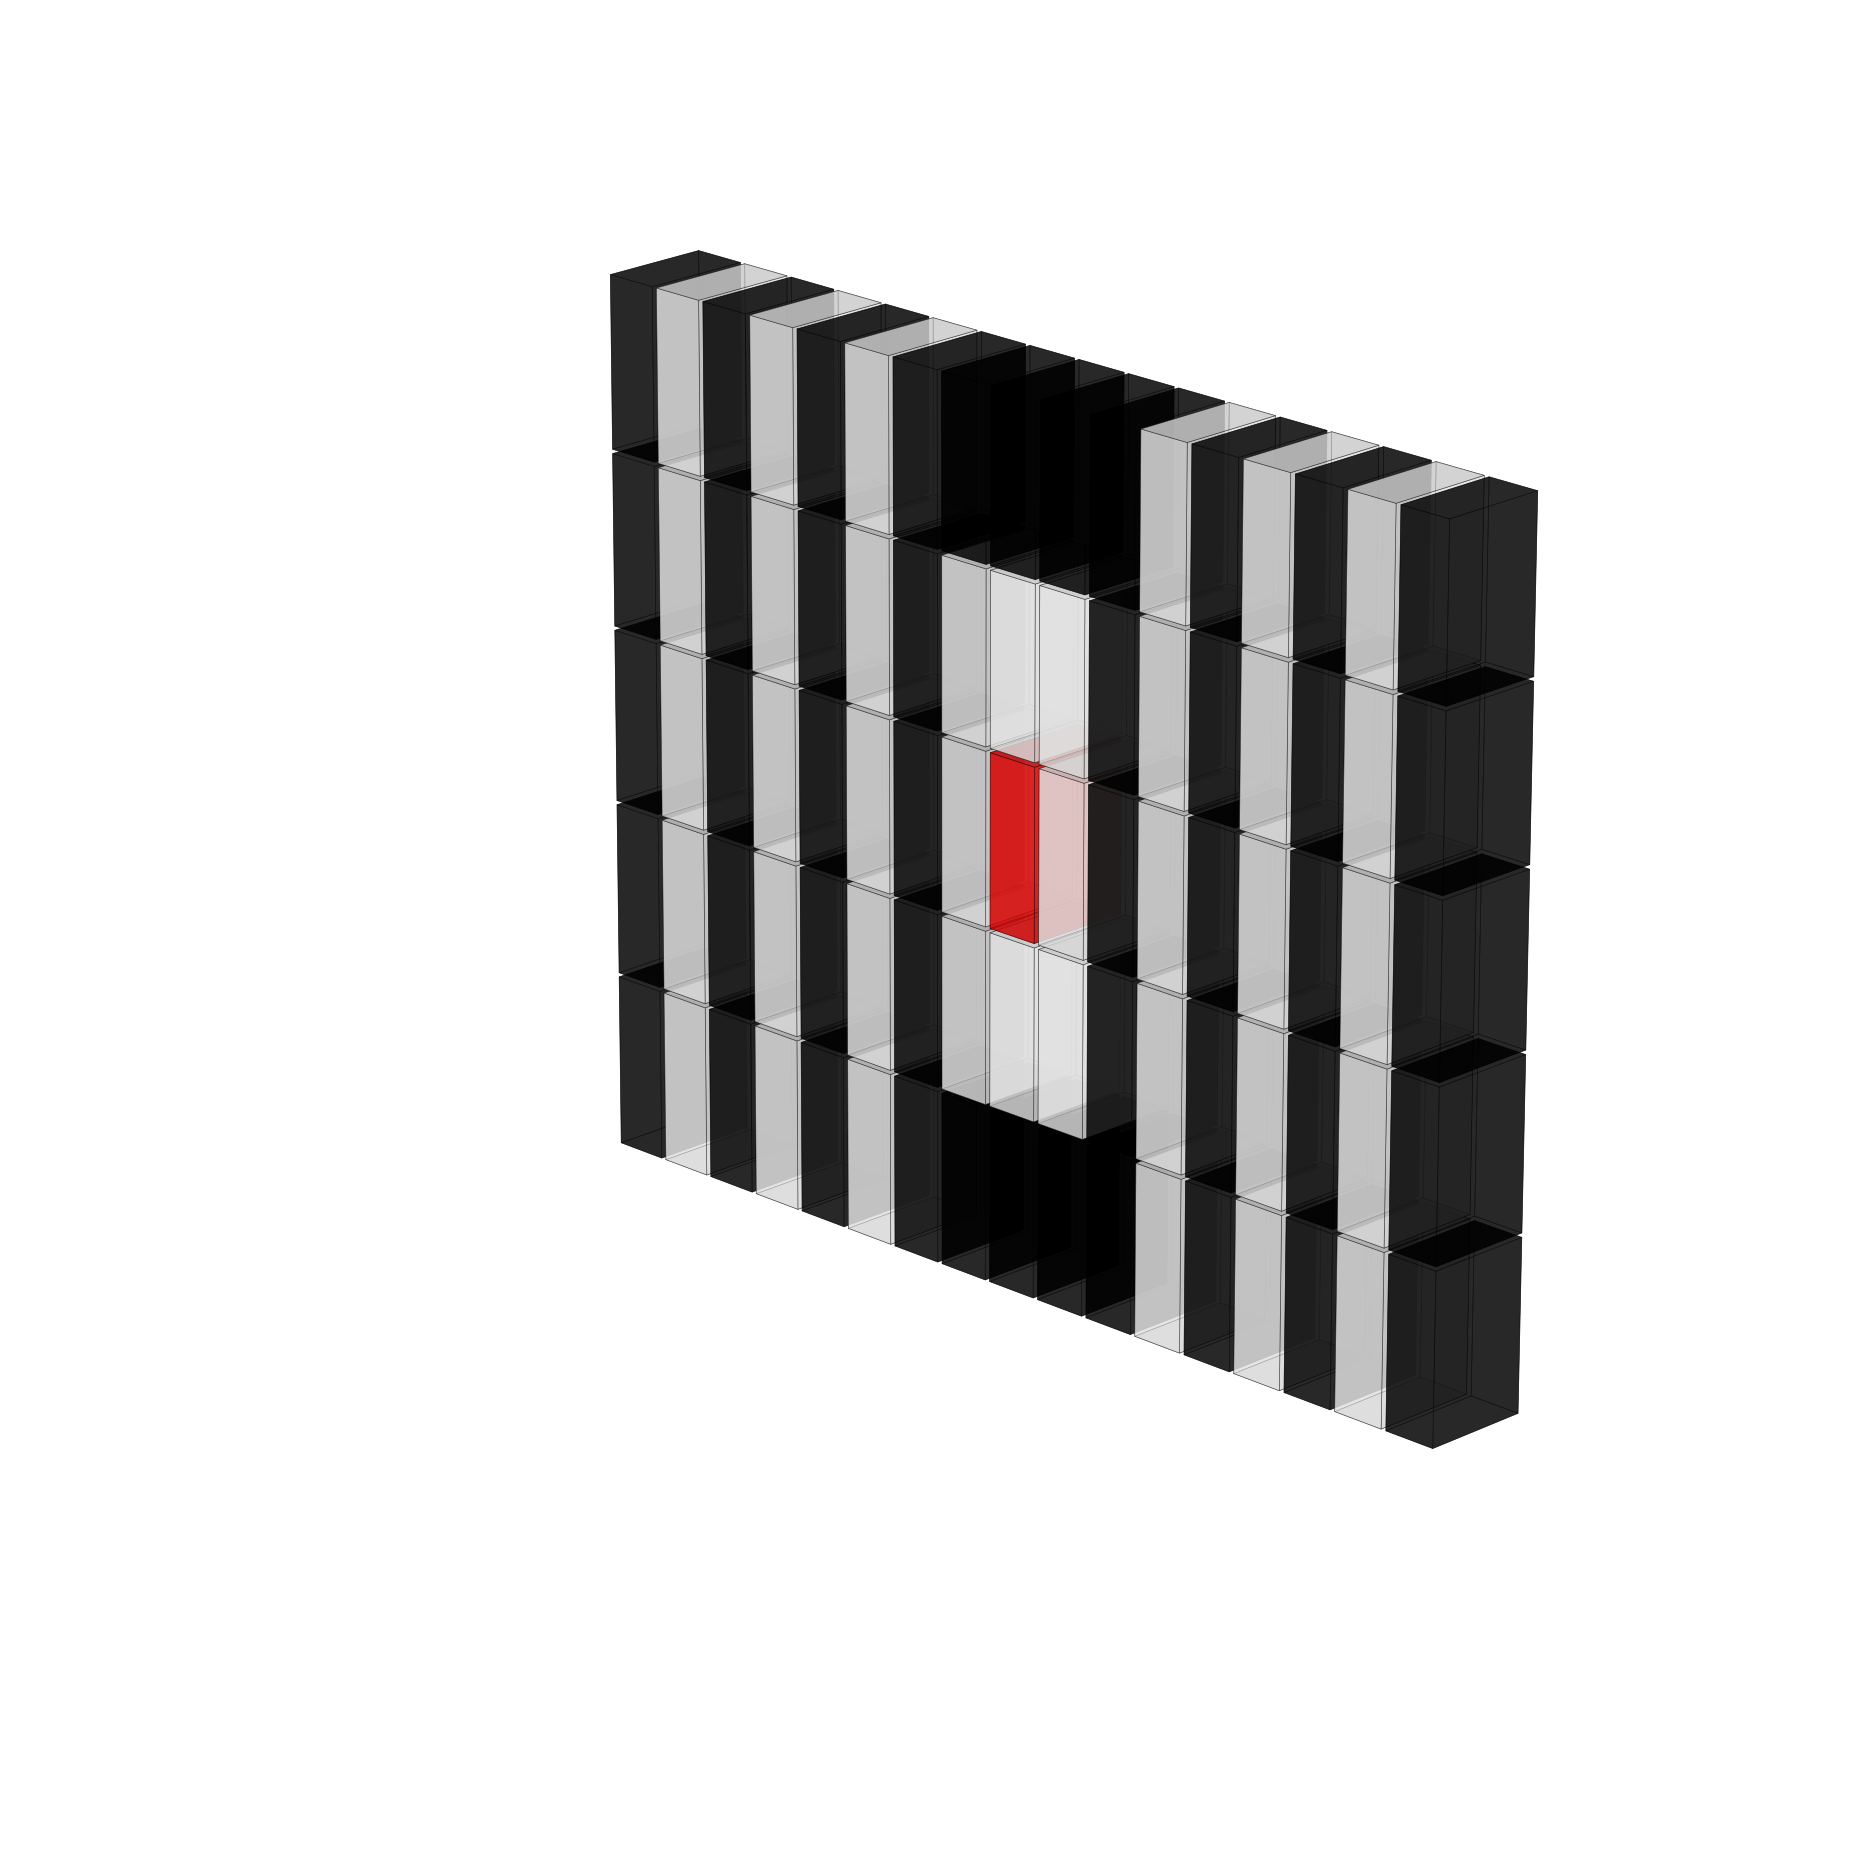

In [4]:
fig = plt.figure(figsize=(10,10), dpi=120)
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
ax_ps = fig.add_subplot(111, projection='3d')
ax_ps.patch.set_facecolor('white')
ax_ps.patch.set_alpha(0)
img_size = (5, 17) # number of cells per side
depth = 1 # number of stacked layers of the same type
grid = np.ones((depth, ) + img_size)

# image settings
plotter = NDArrayPlotter(grid, # default grid
                              alpha=0.6, # opacity
                              spacing=("even", 0.1, 0.1, 0.1), # inter-cube spacing
                              scale=(2, 4, 1))
colors = make_rings_colors(2, 8, 5, 17)
plotter.set_color(np.array([colors]))
plotter.render(ax_ps, azim=45, elev=20, a=0, b=1, c=-6)
plt.savefig('ps.pdf')


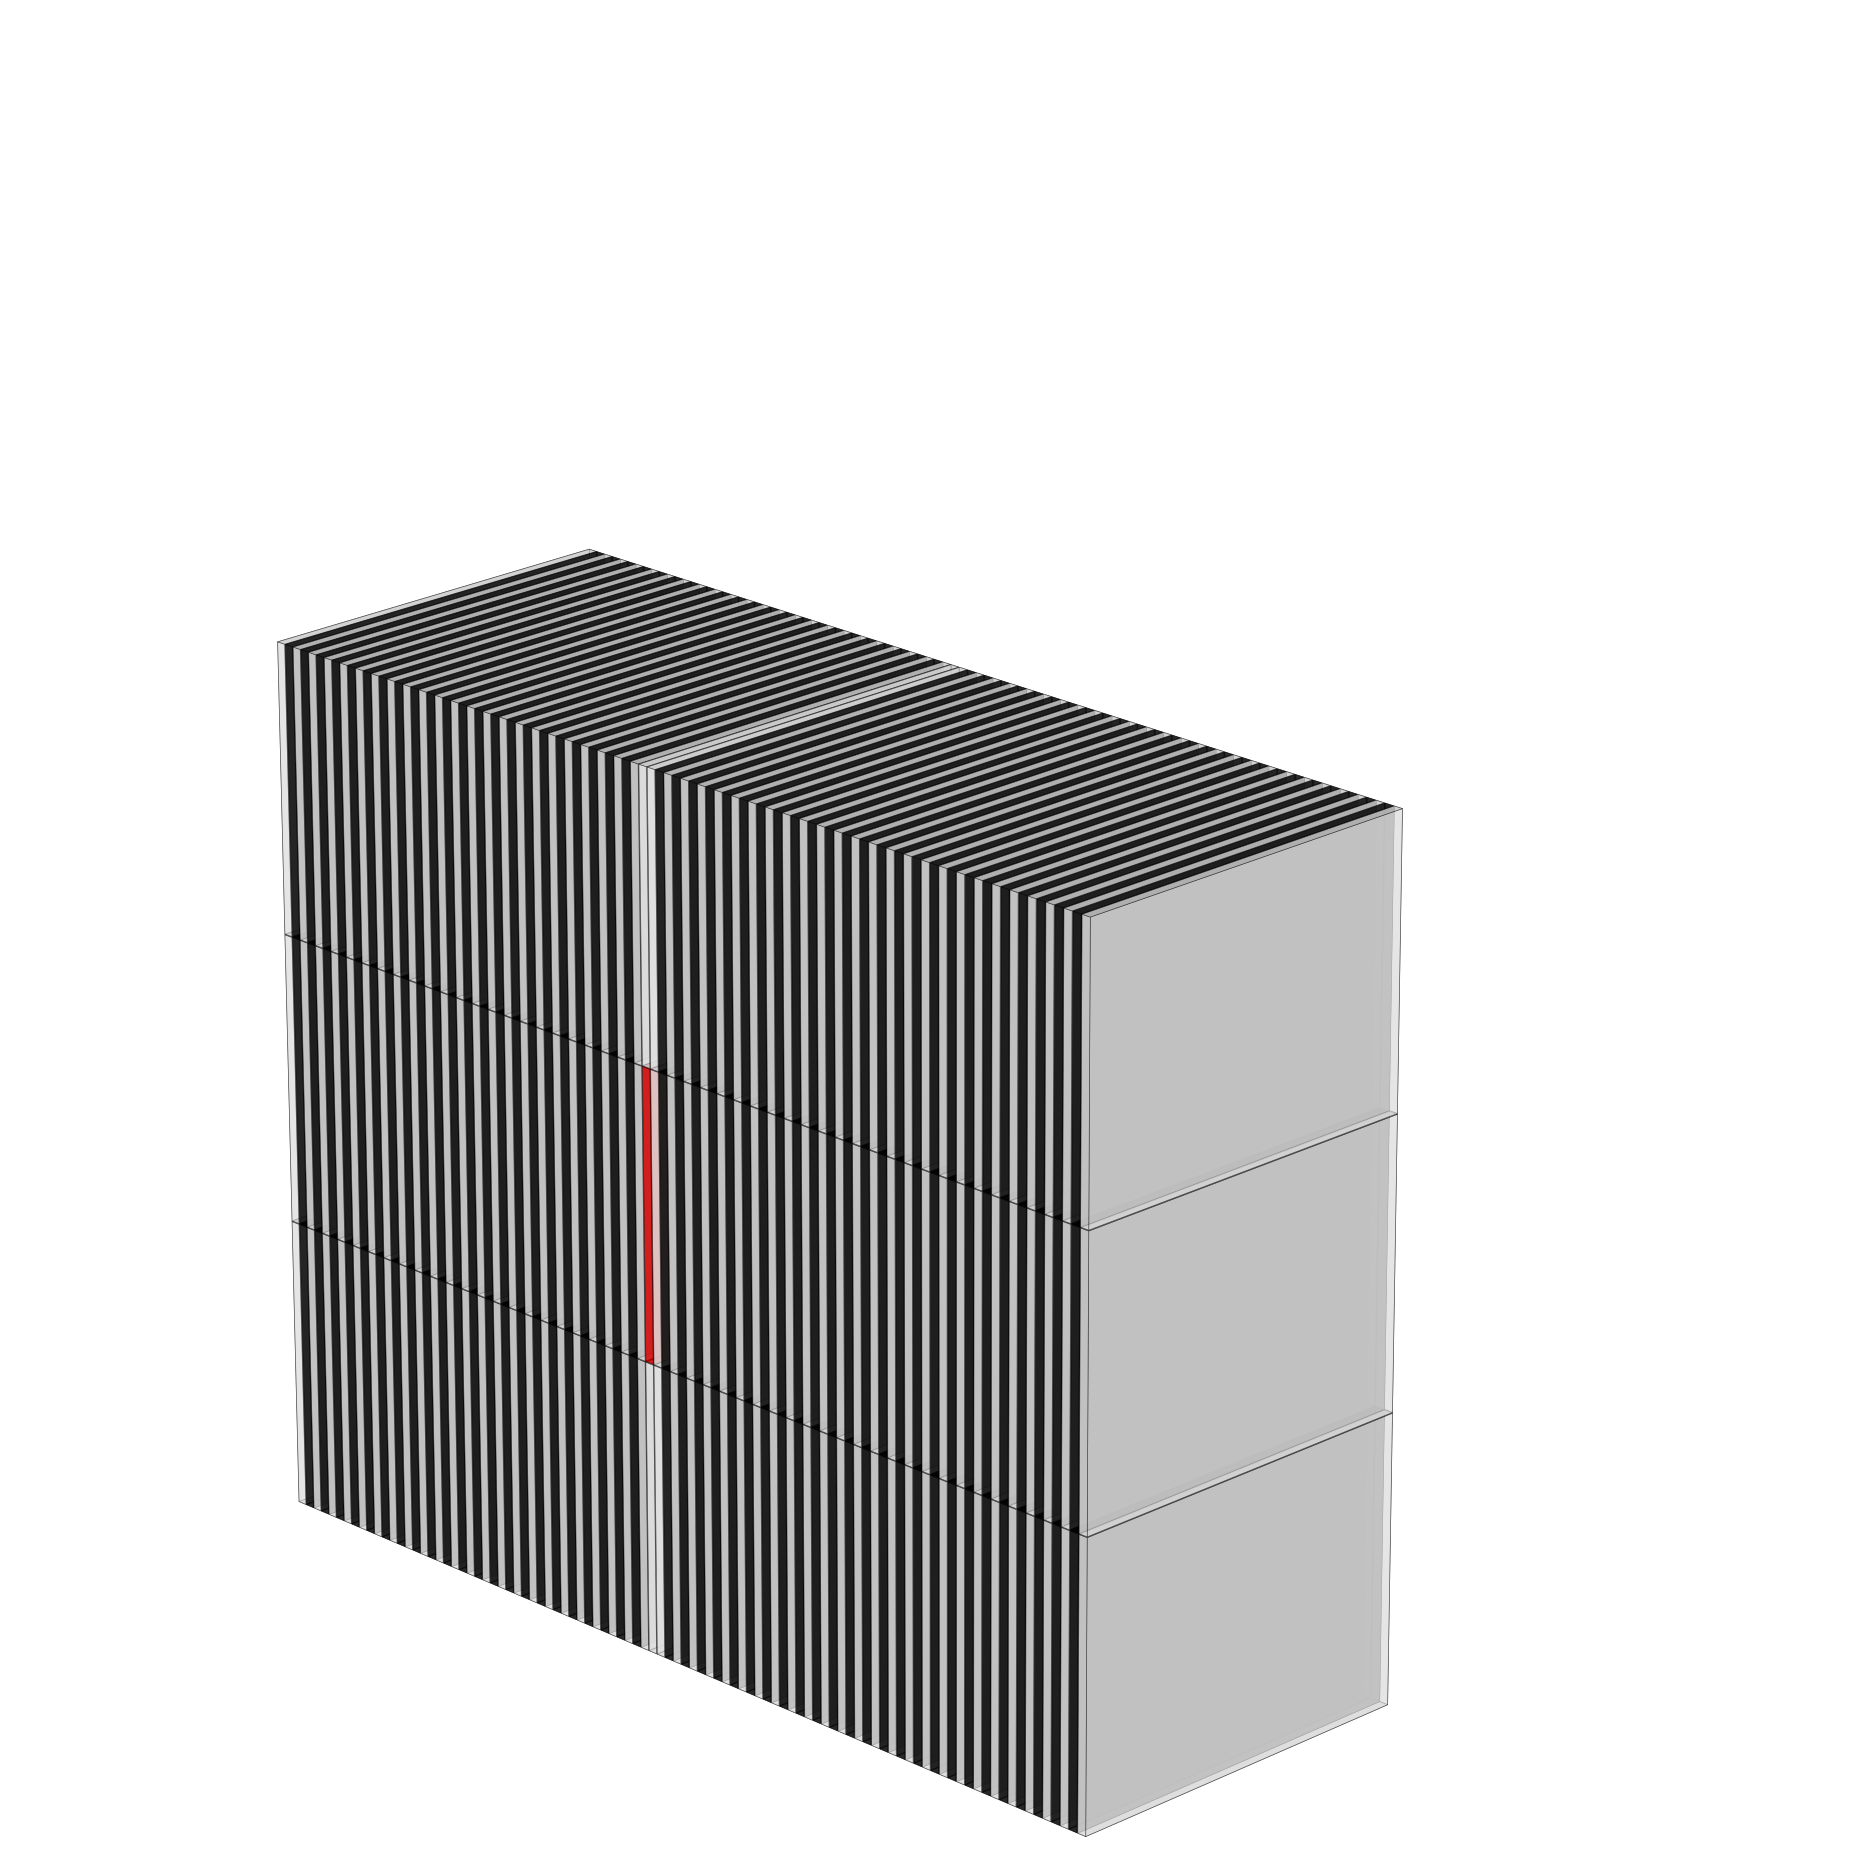

In [5]:
fig = plt.figure(figsize=(10,10), dpi=120)
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
ax_em1 = fig.add_subplot(111, projection='3d')
ax_em1.patch.set_facecolor('white')
ax_em1.patch.set_alpha(0)

img_size = (3, 97)
depth = 1
grid = np.ones((depth, ) + img_size)
plotter = NDArrayPlotter(grid, # default grid
                              alpha=0.6, # opacity
                              spacing=("even", 0.1, 0.1, 0.1), # inter-cube spacing
                              scale=(40, 39, 1)) # relative lengths

colors = make_rings_colors(1, 45, 3, 97)
plotter.set_color(np.array([colors]))
plotter.render(ax_em1, azim=45, elev=20, a=0, b=50, c=-50)
plt.savefig('em1.pdf')

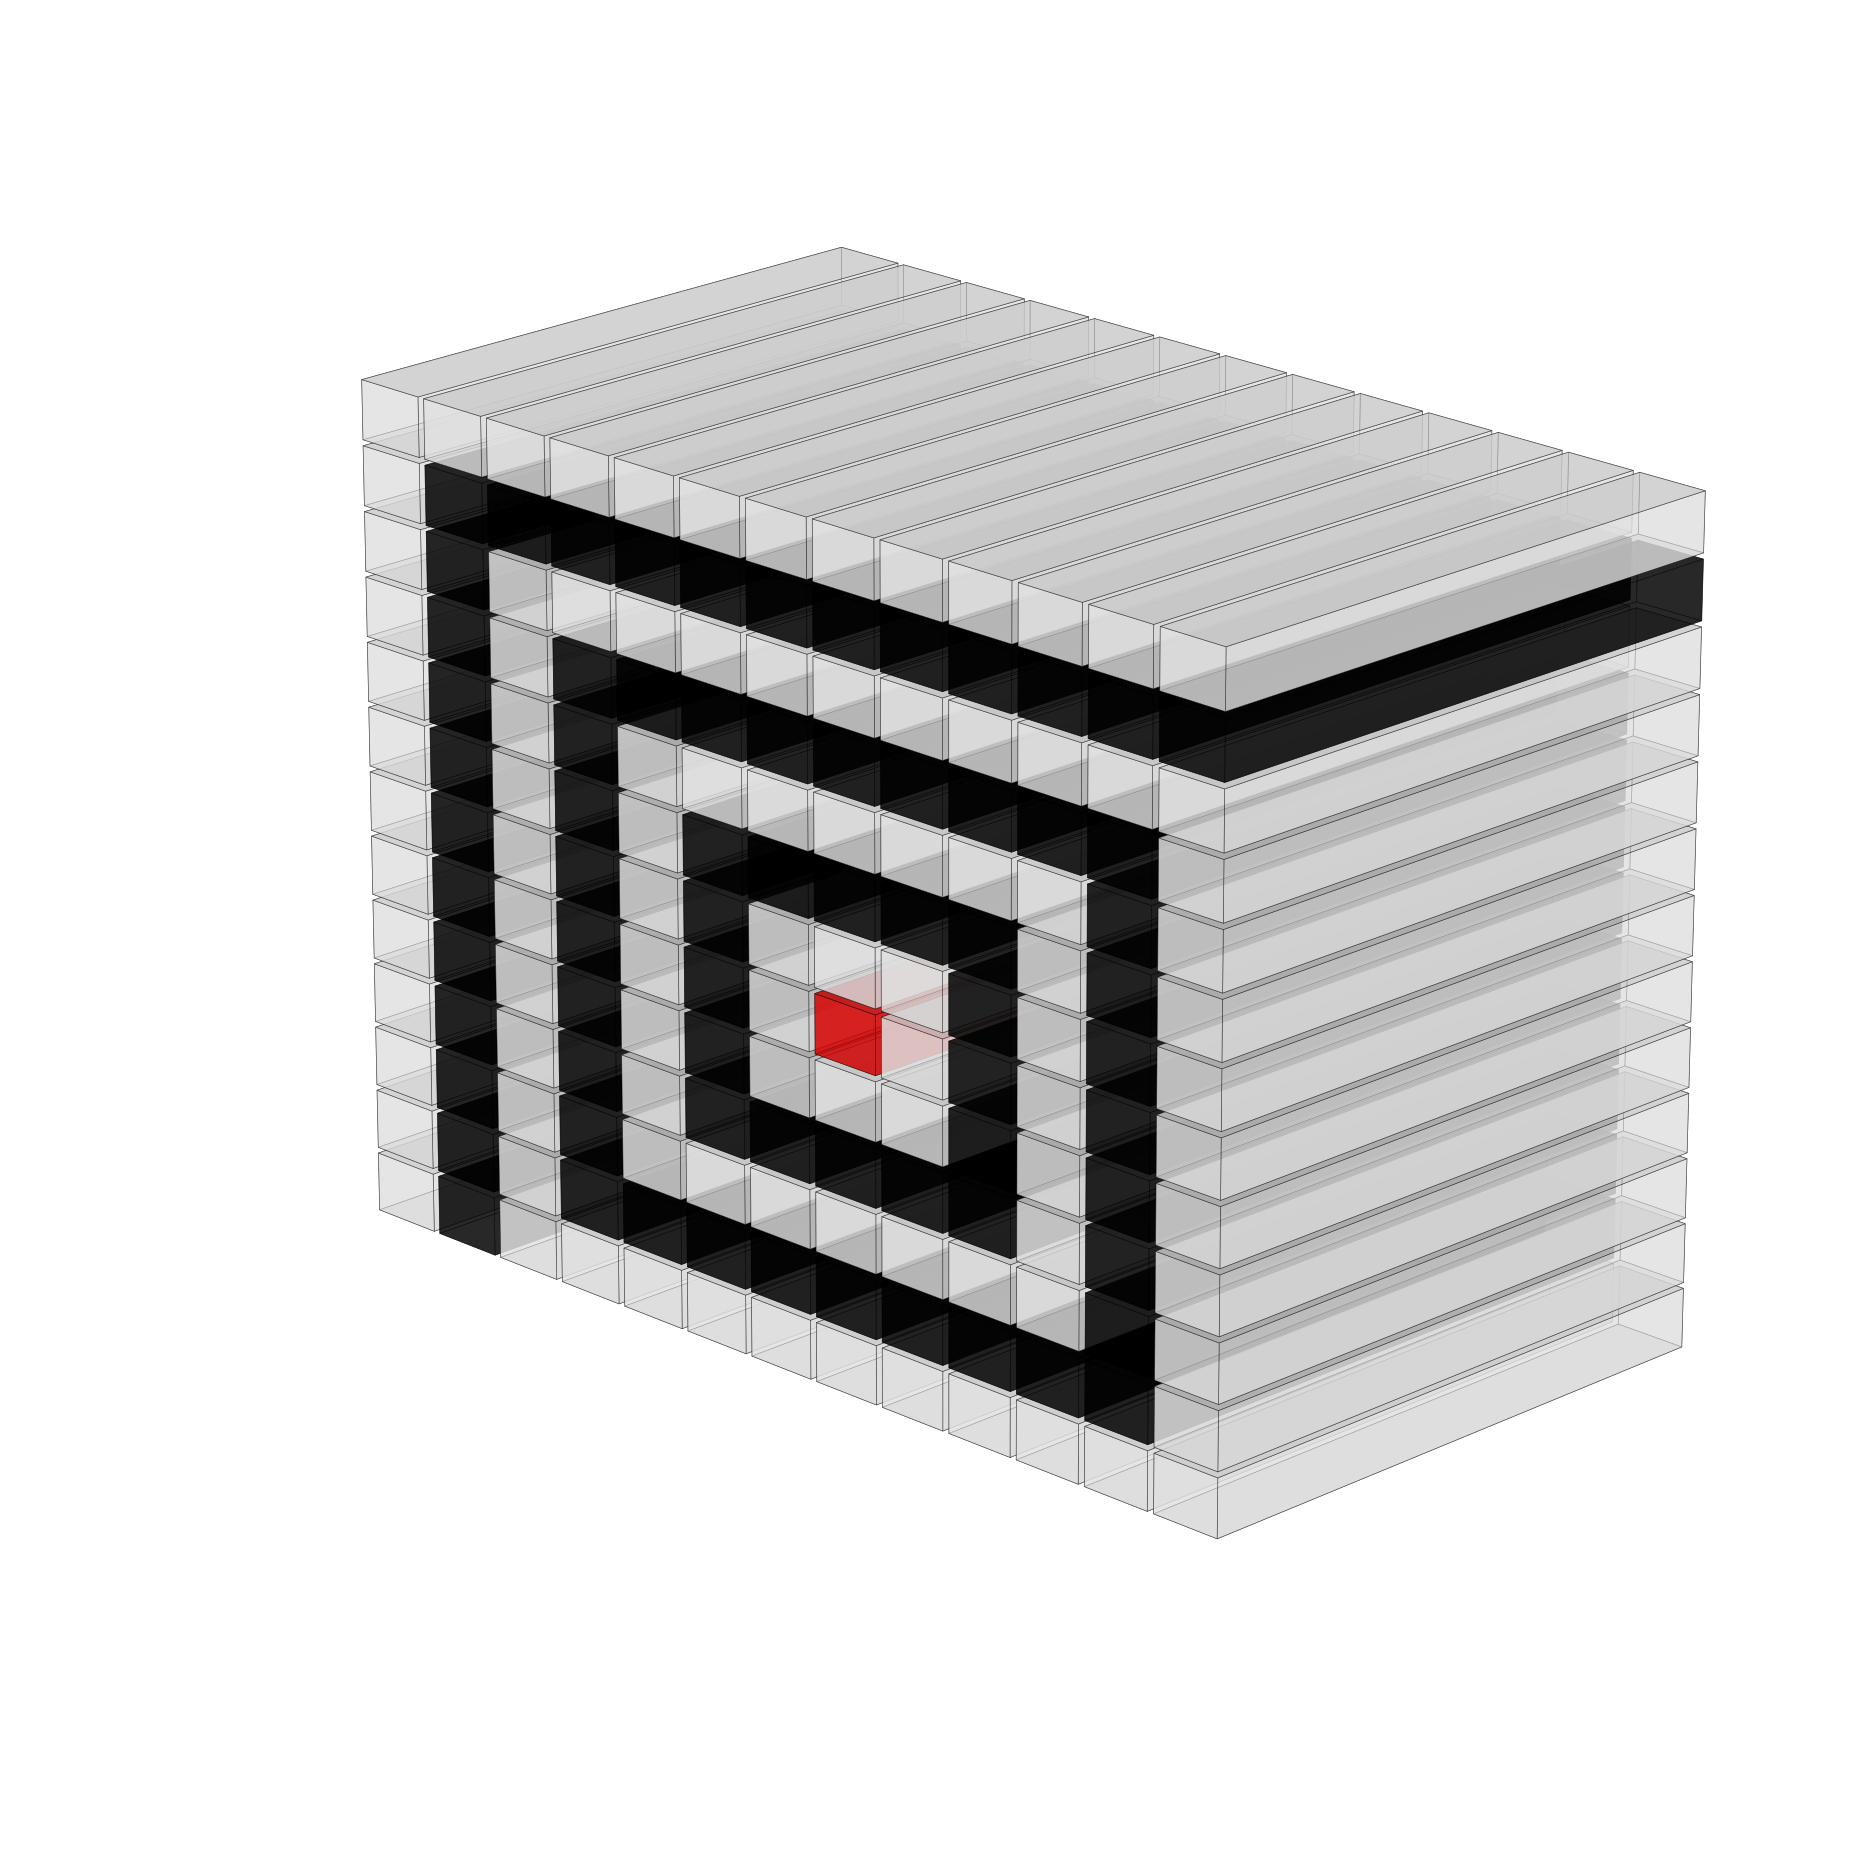

In [6]:
fig = plt.figure(figsize=(10,10), dpi=120)
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
ax_em2 = fig.add_subplot(111, projection='3d')
ax_em2.patch.set_facecolor('white')
ax_em2.patch.set_alpha(0)
img_size = (13, 13) # number of cells per side
depth = 1 # number of stacked layers of the same type
grid = np.ones((depth, ) + img_size)

# image settings
plotter = NDArrayPlotter(grid, # default grid
                              alpha=0.6, # opacity
                              spacing=("even", 0.1, 0.1, 0.1), # inter-cube spacing
                              scale=(8, 1, 1))
colors = make_rings_colors(7, 7, 13, 13)
plotter.set_color(np.array([colors]))
plotter.render(ax_em2, azim=45, elev=20, a=0, b=0, c=-2)
plt.savefig('em2.pdf')

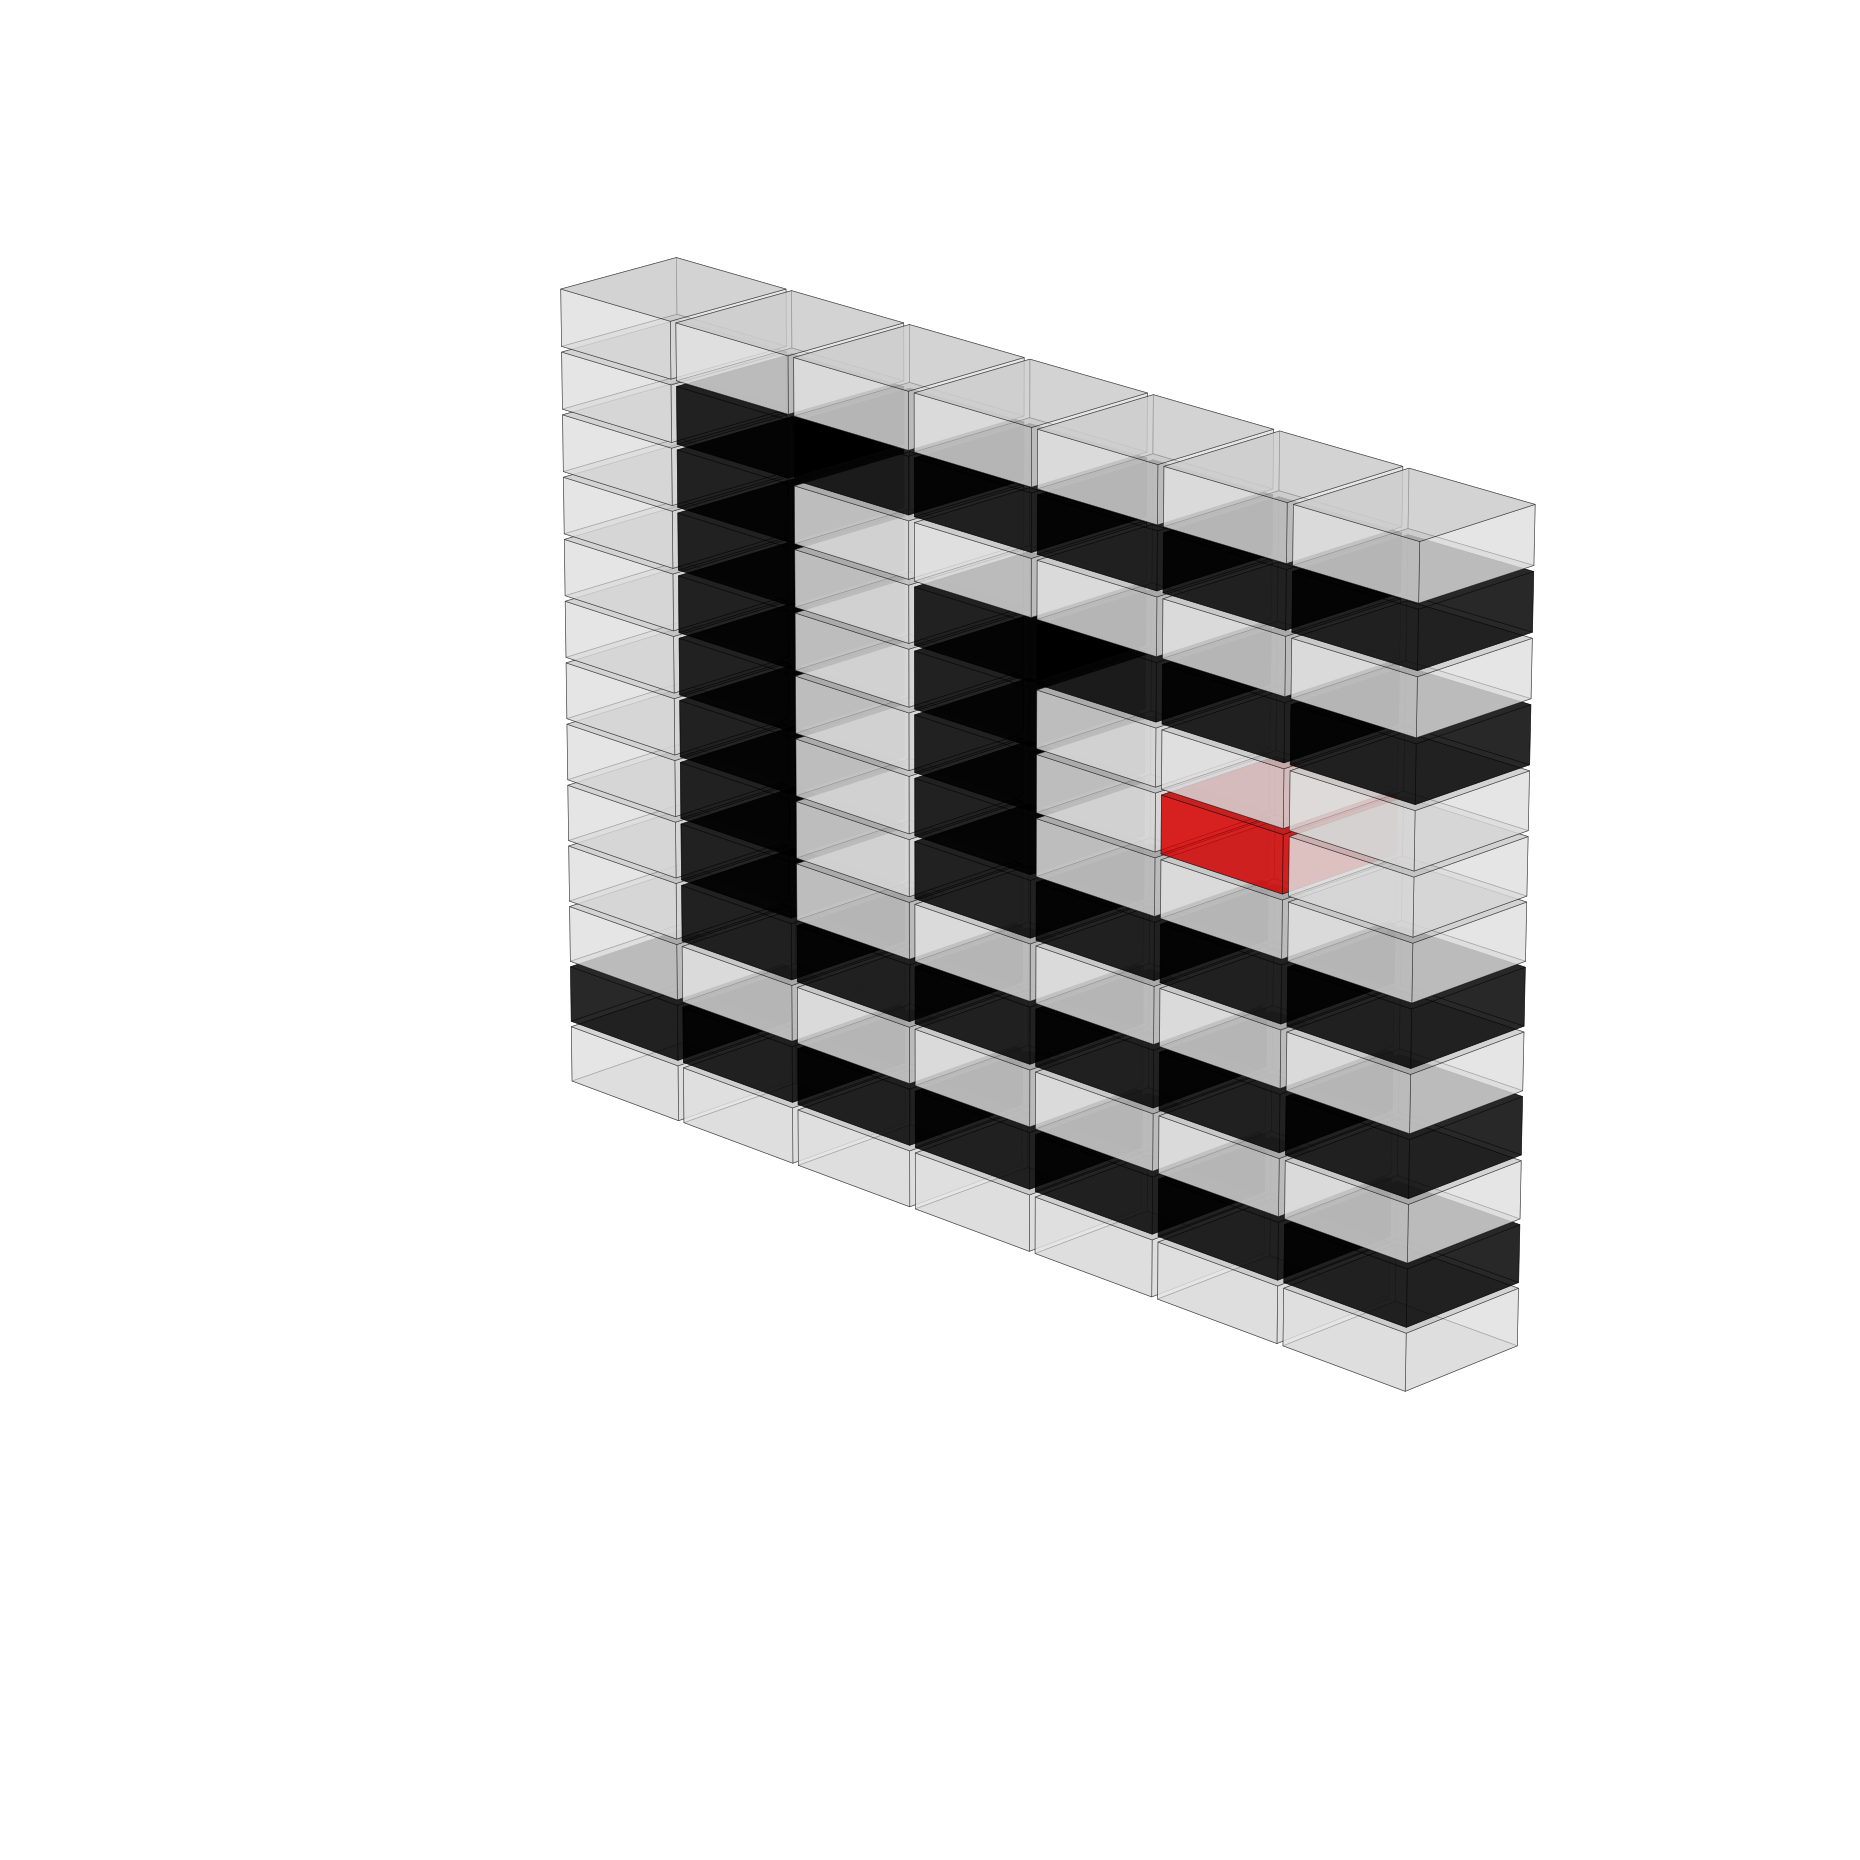

In [7]:
fig = plt.figure(figsize=(10,10), dpi=120)
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
ax_em3 = fig.add_subplot(111, projection='3d')
ax_em3.patch.set_facecolor('white')
ax_em3.patch.set_alpha(0)
img_size = (13, 7) # number of cells per side
depth = 1 # number of stacked layers of the same type
grid = np.ones((depth, ) + img_size)

# image settings
plotter = NDArrayPlotter(grid, # default grid
                              alpha=0.6, # opacity
                              spacing=("even", 0.1, 0.1, 0.1), # inter-cube spacing
                              scale=(2, 1, 2))
colors = make_rings_colors(5, 5, 13, 7)
plotter.set_color(np.array([colors]))
plotter.render(ax_em3, azim=45, elev=20, a=0, b=1, c=-5)
plt.savefig('em3.pdf')

## Create Hadronic Layers:

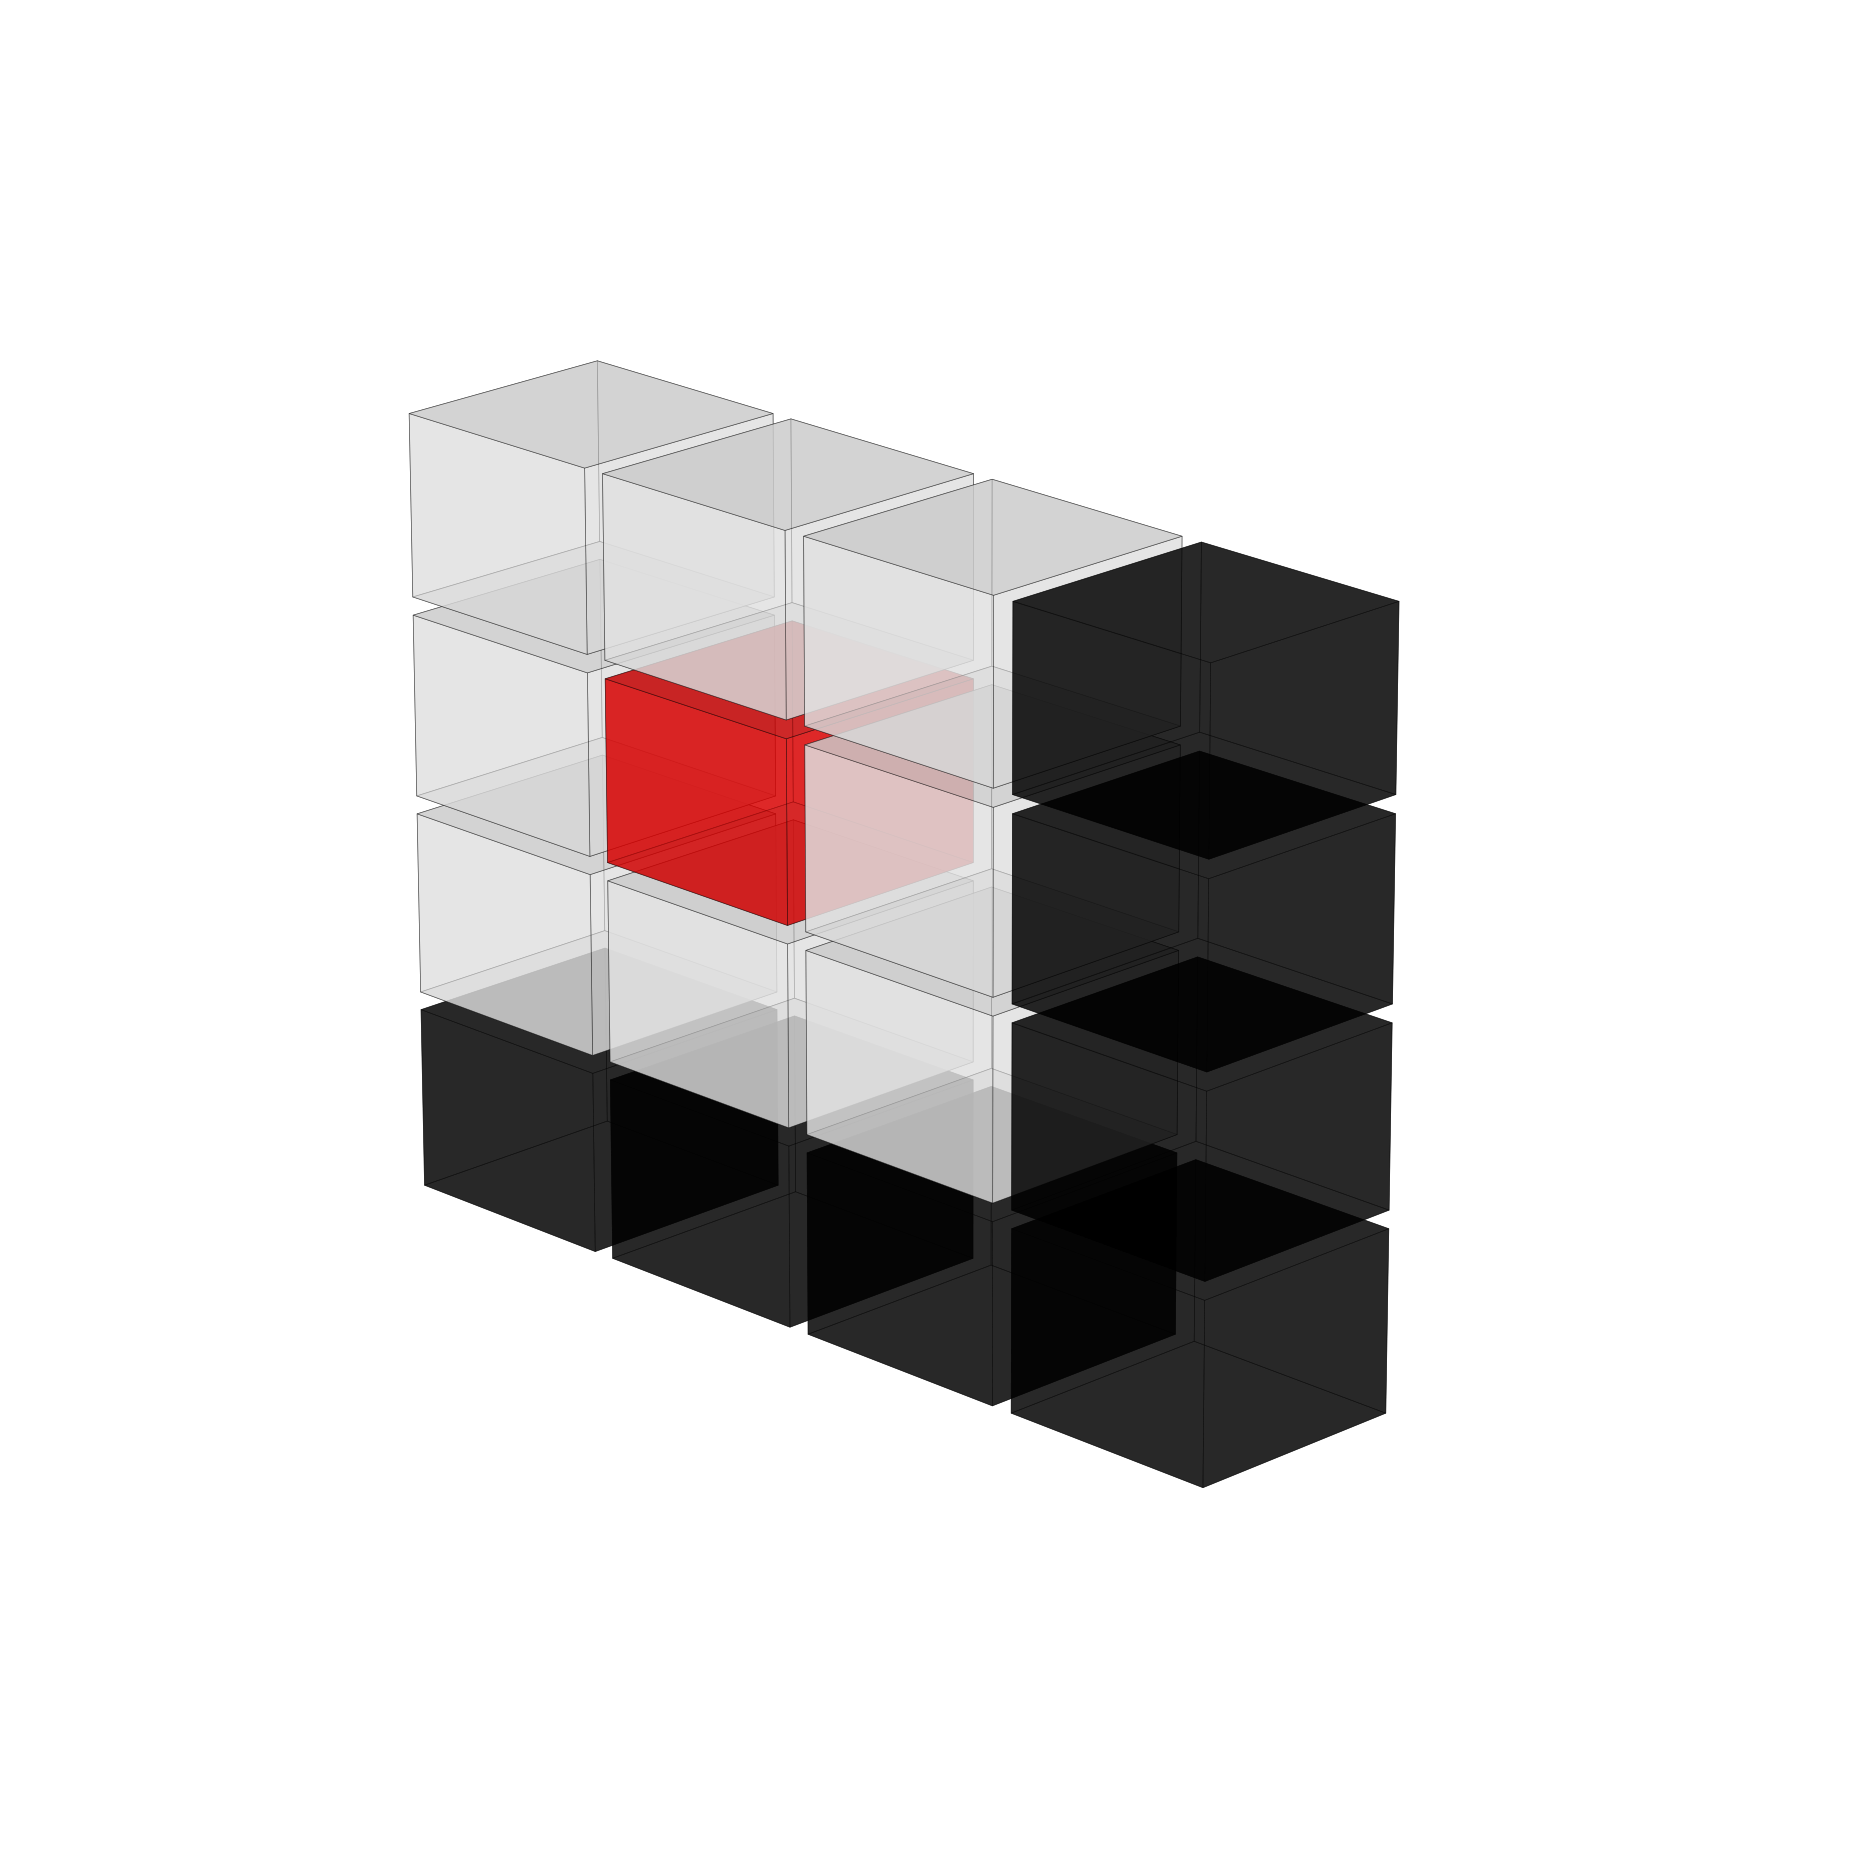

In [8]:
fig = plt.figure(figsize=(10,10), dpi=120)
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
ax_had1 = fig.add_subplot(111, projection='3d')
ax_had1.patch.set_facecolor('white')
ax_had1.patch.set_alpha(0)
img_size = (4, 4) # number of cells per side
depth = 1 # number of stacked layers of the same type
grid = np.ones((depth, ) + img_size)

# image settings
plotter = NDArrayPlotter(grid, # default grid
                              alpha=0.6, # opacity
                              spacing=("even", 0.1, 0.1, 0.1), # inter-cube spacing
                              scale=(1, 1, 1))
colors = make_rings_colors(1, 1, 4, 4)
plotter.set_color(np.array([colors]))
plotter.render(ax_had1, azim=45, elev=20, a=0, b=1, c=-2)
plt.savefig('had1.pdf')

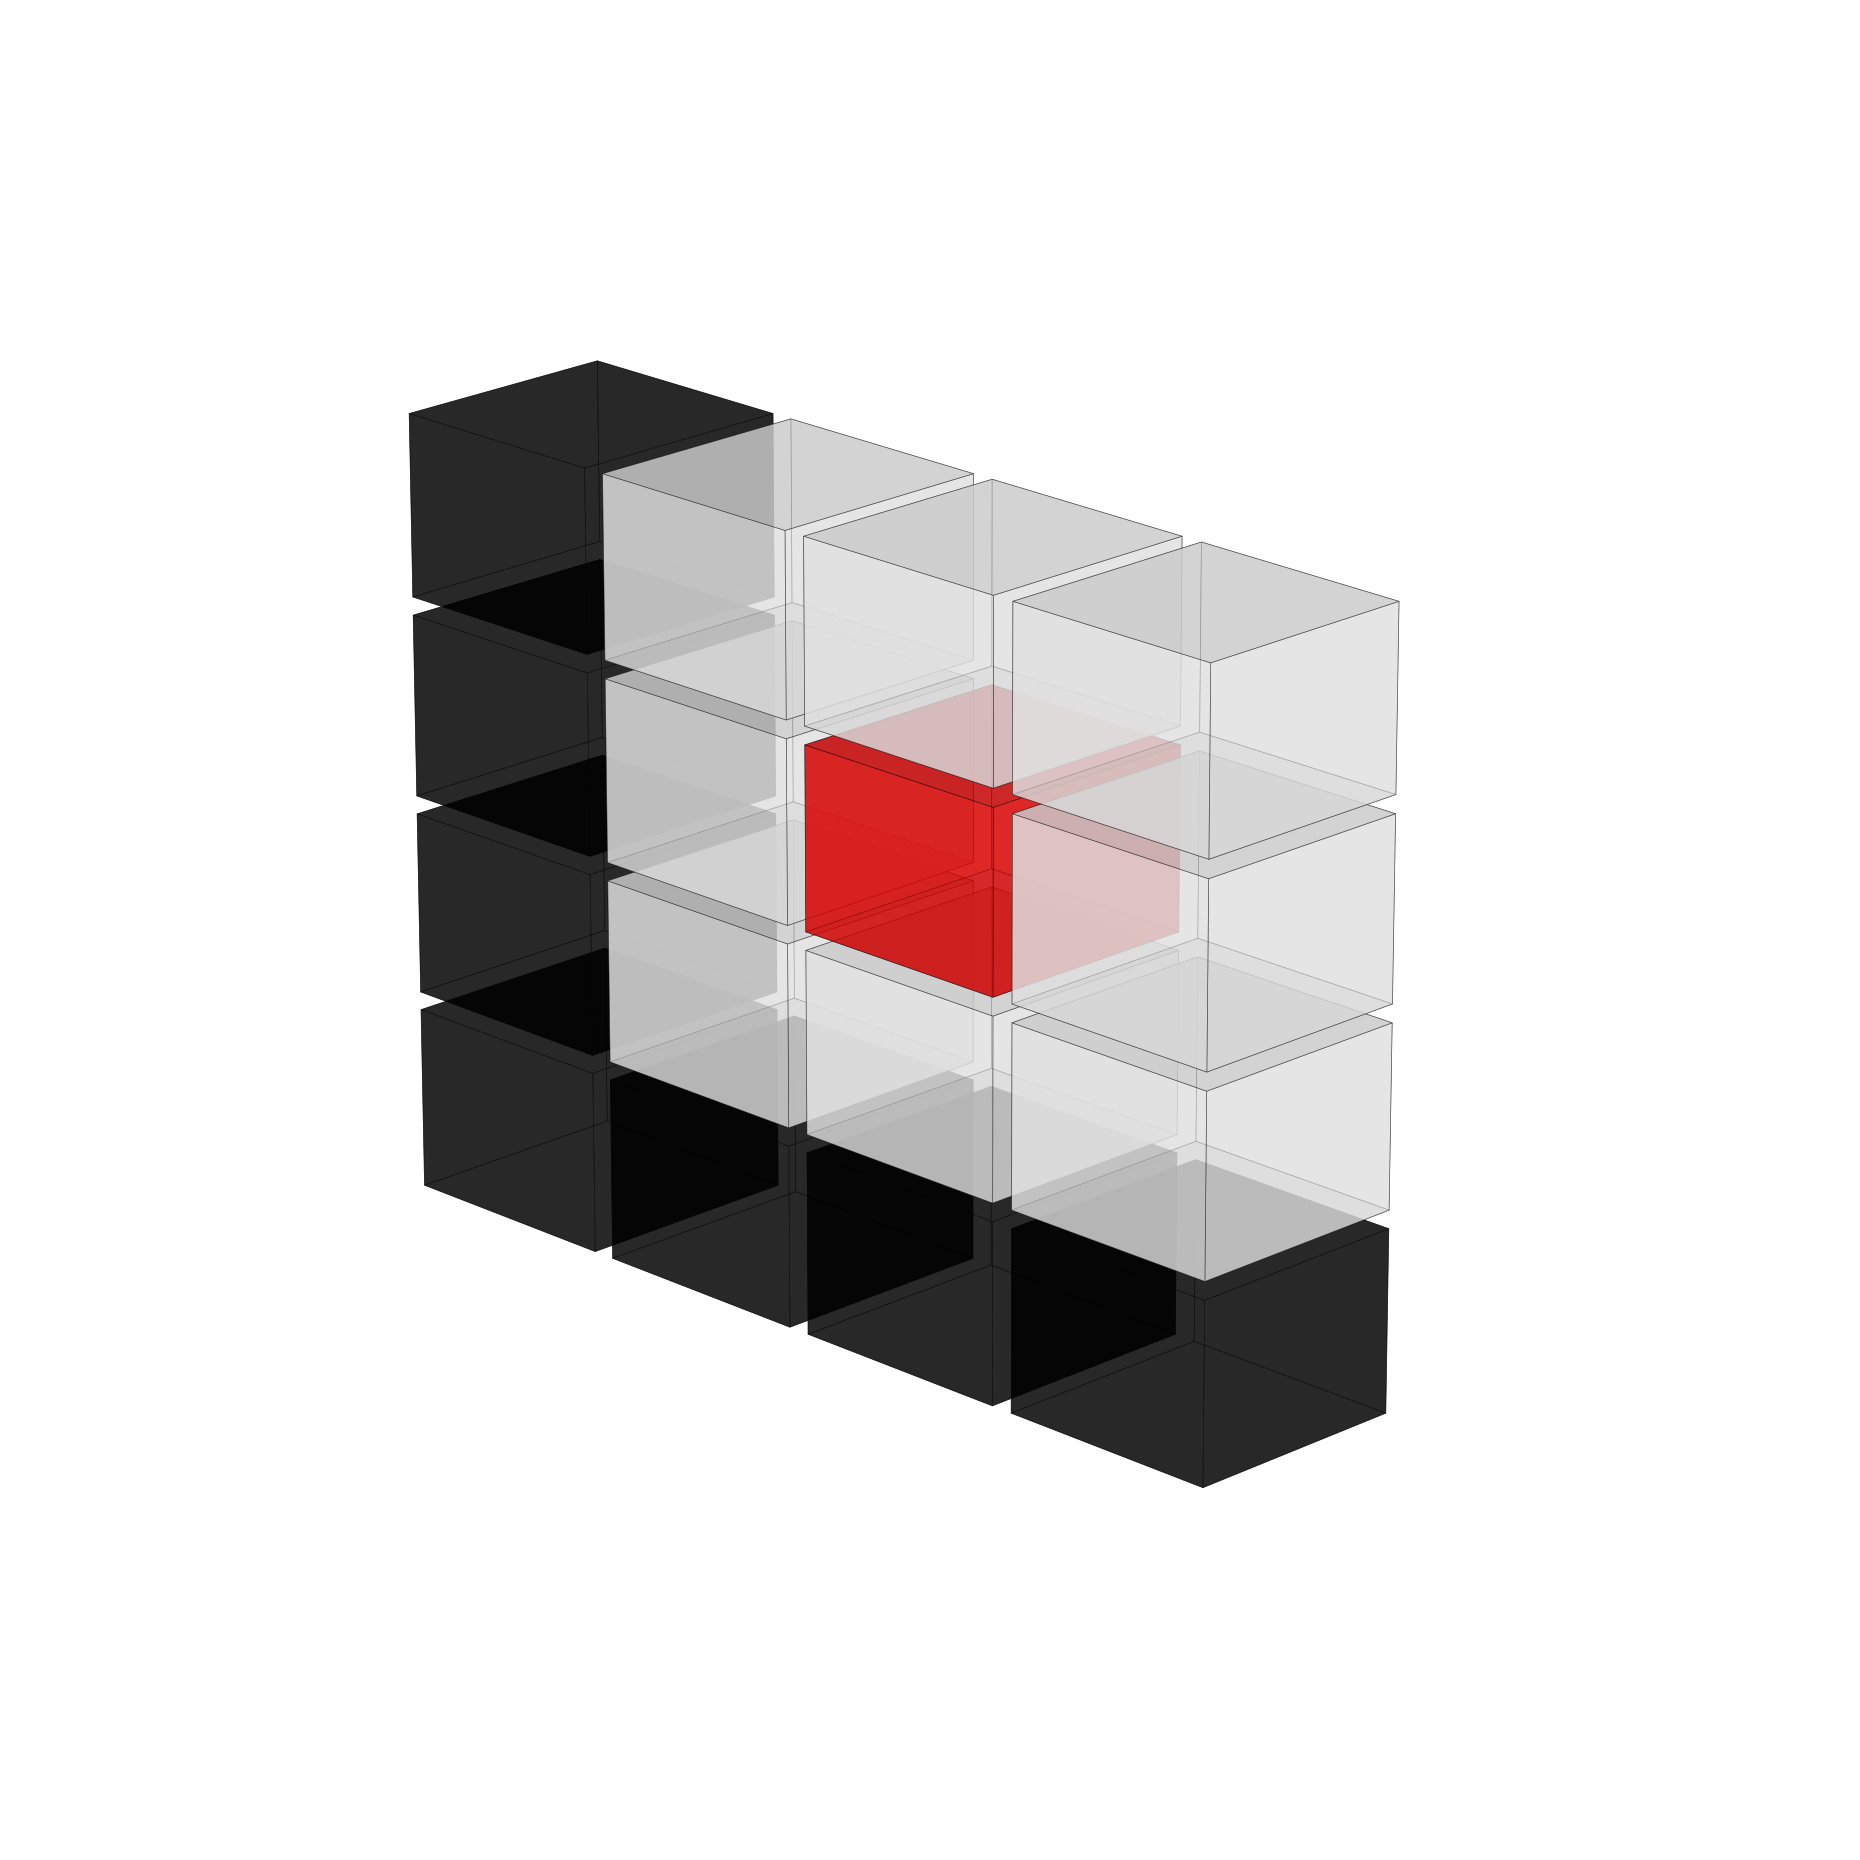

In [9]:
fig = plt.figure(figsize=(10,10), dpi=120)
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
ax_had2 = fig.add_subplot(111, projection='3d')
ax_had2.patch.set_facecolor('white')
ax_had2.patch.set_alpha(0)
img_size = (4, 4) # number of cells per side
depth = 1 # number of stacked layers of the same type
grid = np.ones((depth, ) + img_size)

# image settings
plotter = NDArrayPlotter(grid, # default grid
                              alpha=0.6, # opacity
                              spacing=("even", 0.1, 0.1, 0.1), # inter-cube spacing
                              scale=(1, 1, 1))
colors = make_rings_colors(1, 2, 4, 4)
plotter.set_color(np.array([colors]))
plotter.render(ax_had2, azim=45, elev=20, a=0, b=1, c=-2)
plt.savefig('had2.pdf')

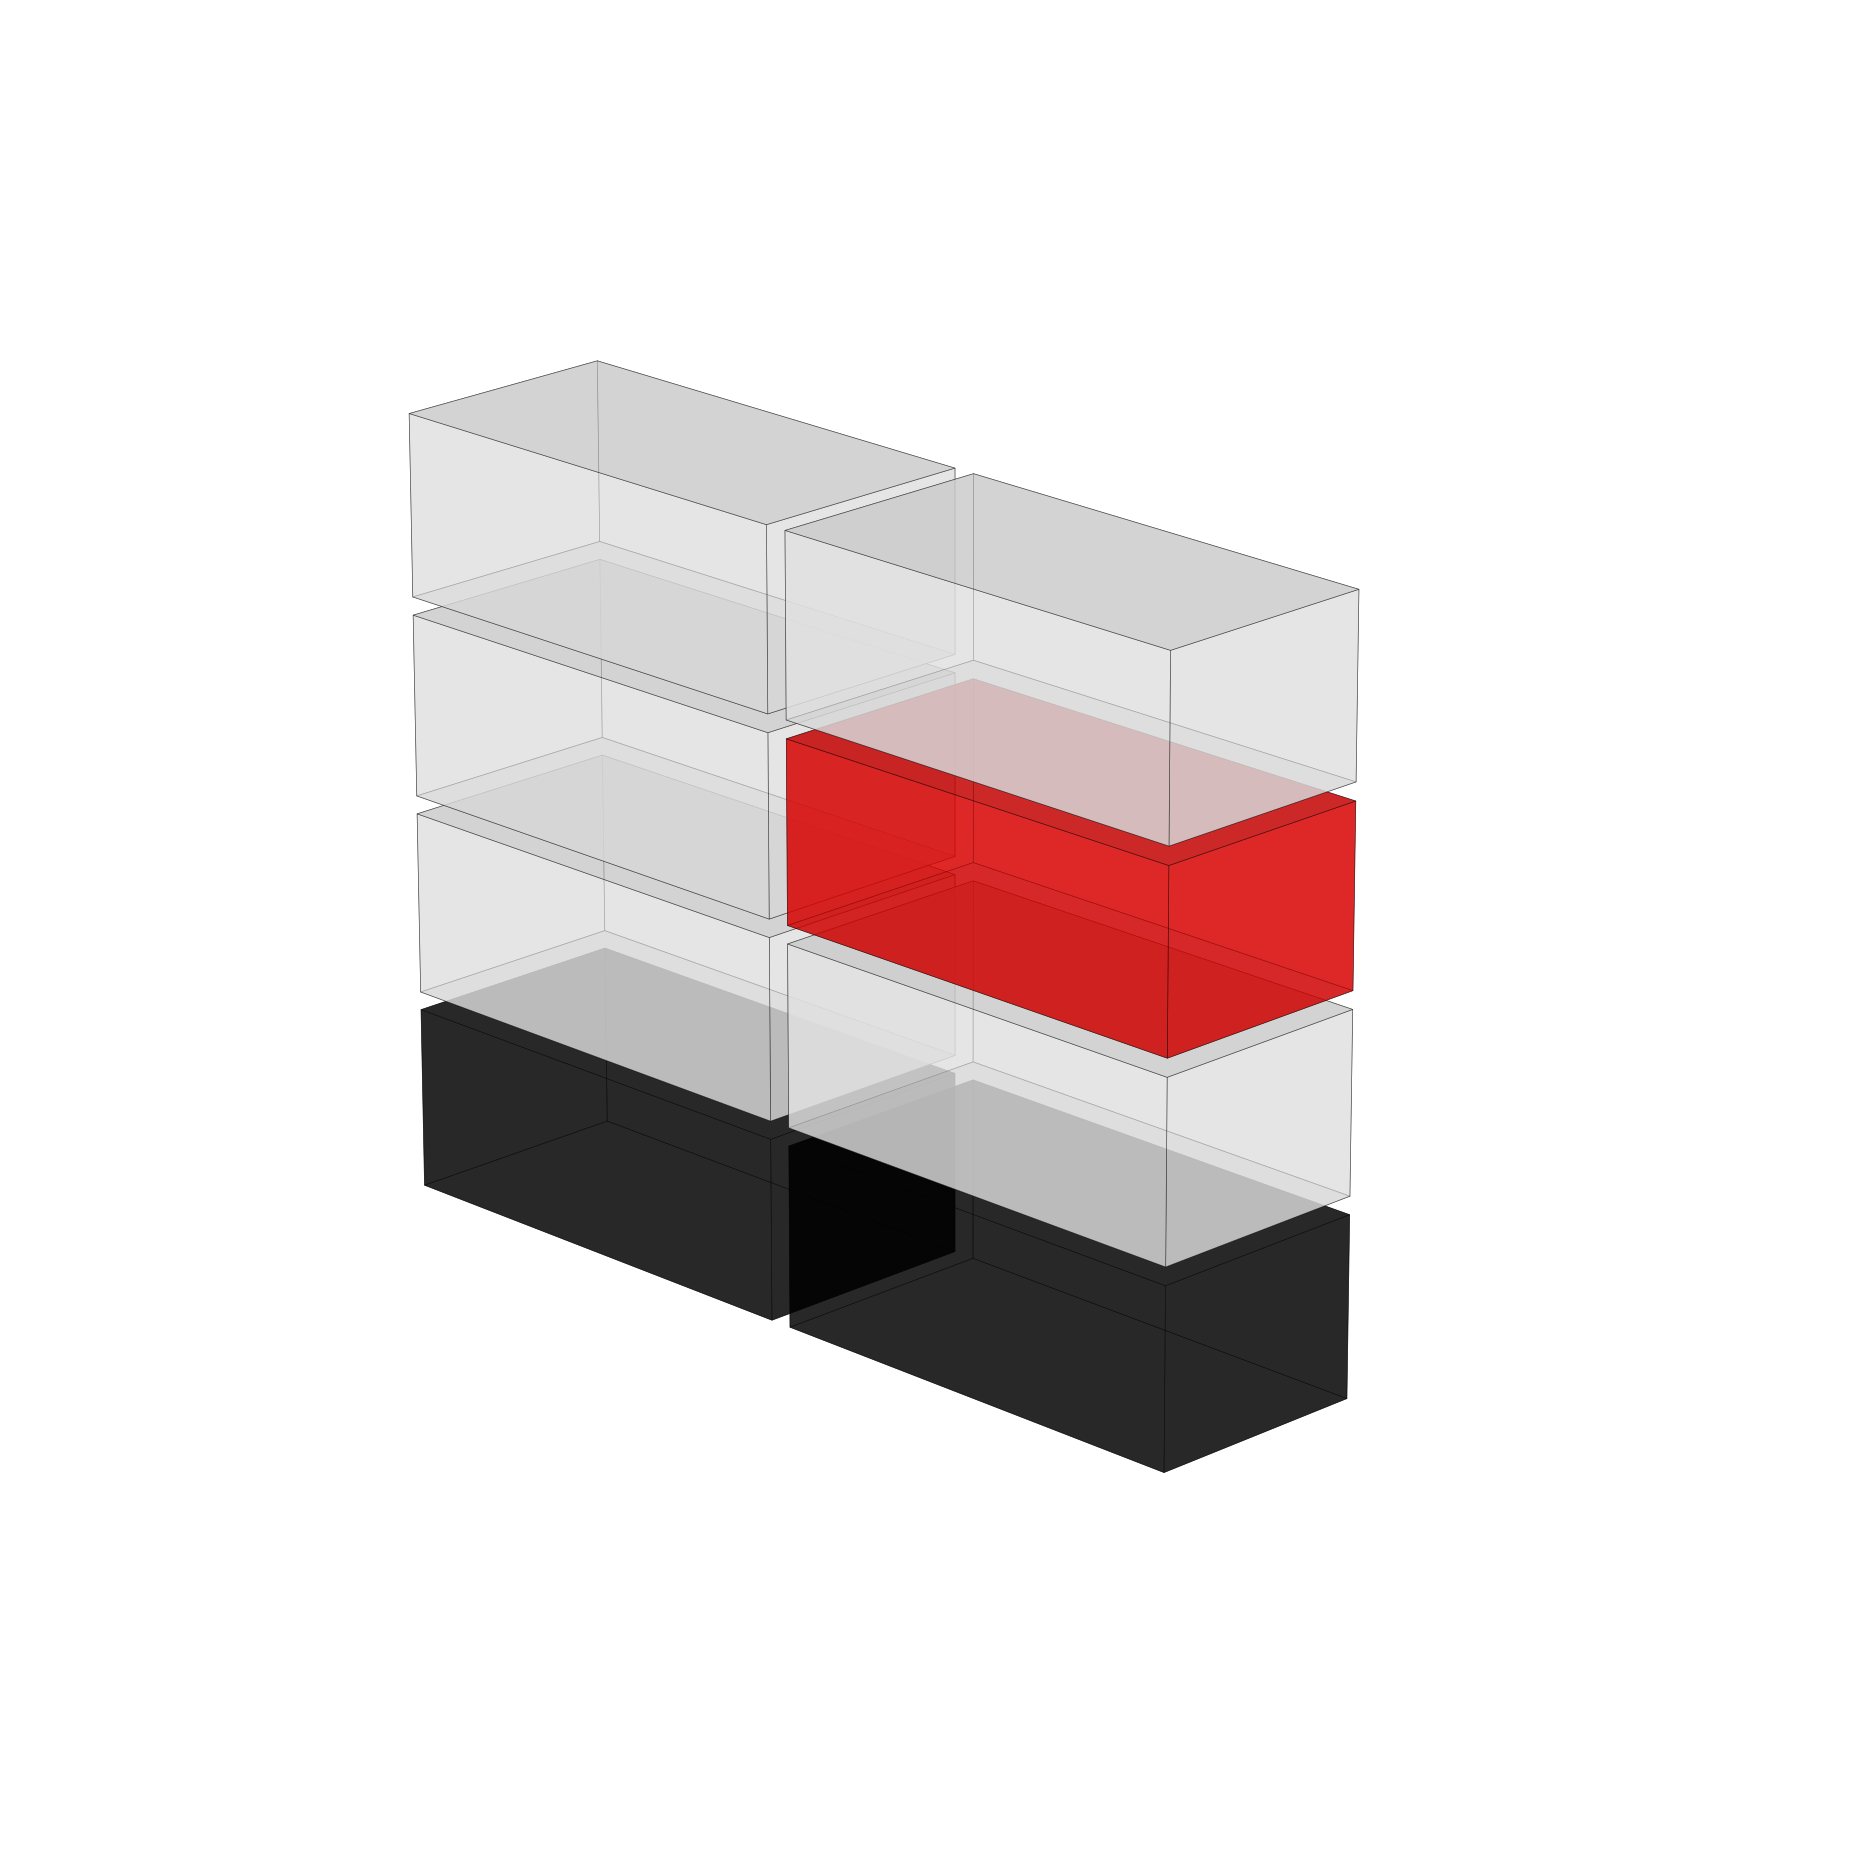

In [10]:
fig = plt.figure(figsize=(10,10), dpi=120)
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
ax_had3 = fig.add_subplot(111, projection='3d')
ax_had3.patch.set_facecolor('white')
ax_had3.patch.set_alpha(0)
img_size = (4, 2) # number of cells per side
depth = 1 # number of stacked layers of the same type
grid = np.ones((depth, ) + img_size)

# image settings
plotter = NDArrayPlotter(grid, # default grid
                              alpha=0.6, # opacity
                              spacing=("even", 0.1, 0.1, 0.1), # inter-cube spacing
                              scale=(1, 1, 2))
colors = make_rings_colors(1, 1, 4, 2)
plotter.set_color(np.array([colors]))
plotter.render(ax_had3, azim=45, elev=20, a=0, b=1, c=-2)
plt.savefig('had3.pdf')

## Simulated plots:

In [2]:
from Gaugi import load
data_electron = load('/Volumes/castor/cern_data/simulation/simulated_electrons.npz')
data_jets = load('/Volumes/castor/cern_data/simulation/simulated_jets.npz')

Welcome to JupyROOT 6.23/01
Using all sub packages with ROOT dependence


In [3]:
data_jets.keys()

dict_keys(['features', 'data', 'cells_ps', 'cells_em1', 'cells_em2', 'cells_em3', 'cells_had1', 'cells_had2', 'cells_had3'])

In [4]:
data_electron['cells_em1'].shape

(8, 3, 85)

In [5]:
data_electron['features']

array(['avgmu', 'ring_0', 'ring_1', 'ring_2', 'ring_3', 'ring_4',
       'ring_5', 'ring_6', 'ring_7', 'ring_8', 'ring_9', 'ring_10',
       'ring_11', 'ring_12', 'ring_13', 'ring_14', 'ring_15', 'ring_16',
       'ring_17', 'ring_18', 'ring_19', 'ring_20', 'ring_21', 'ring_22',
       'ring_23', 'ring_24', 'ring_25', 'ring_26', 'ring_27', 'ring_28',
       'ring_29', 'ring_30', 'ring_31', 'ring_32', 'ring_33', 'ring_34',
       'ring_35', 'ring_36', 'ring_37', 'ring_38', 'ring_39', 'ring_40',
       'ring_41', 'ring_42', 'ring_43', 'ring_44', 'ring_45', 'ring_46',
       'ring_47', 'ring_48', 'ring_49', 'ring_50', 'ring_51', 'ring_52',
       'ring_53', 'ring_54', 'ring_55', 'ring_56', 'ring_57', 'ring_58',
       'ring_59', 'ring_60', 'ring_61', 'ring_62', 'ring_63', 'ring_64',
       'ring_65', 'ring_66', 'ring_67', 'ring_68', 'ring_69', 'ring_70',
       'ring_71', 'ring_72', 'ring_73', 'ring_74', 'ring_75', 'ring_76',
       'ring_77', 'ring_78', 'ring_79', 'ring_80', 'ring_81', '

In [8]:
def plot_image(image, _x, _y, outname,vmin=None, vmax=None):
    fig = plt.figure(figsize=(10,10))
    im = plt.imshow(image,aspect=_x/_y,interpolation='nearest',norm=LogNorm(vmin, vmax),
                    cmap=plt.get_cmap('RdBu'))
    cbar = plt.colorbar(fraction=0.0455)
    cbar.set_label(r'Energy (MeV)', y=0.83, fontsize = 30)
    cbar.ax.tick_params()
    xticks = range(_x)
    yticks = range(_y)
    xticks = xticks[::10]
    plt.xticks(xticks)
    plt.yticks(yticks)
    plt.xlabel(r'$\eta$ Cell ID',fontsize = 30)
    plt.ylabel(r'$\phi$ Cell ID', fontsize = 30)
    plt.tight_layout()
    fig.savefig(outname)
    return im

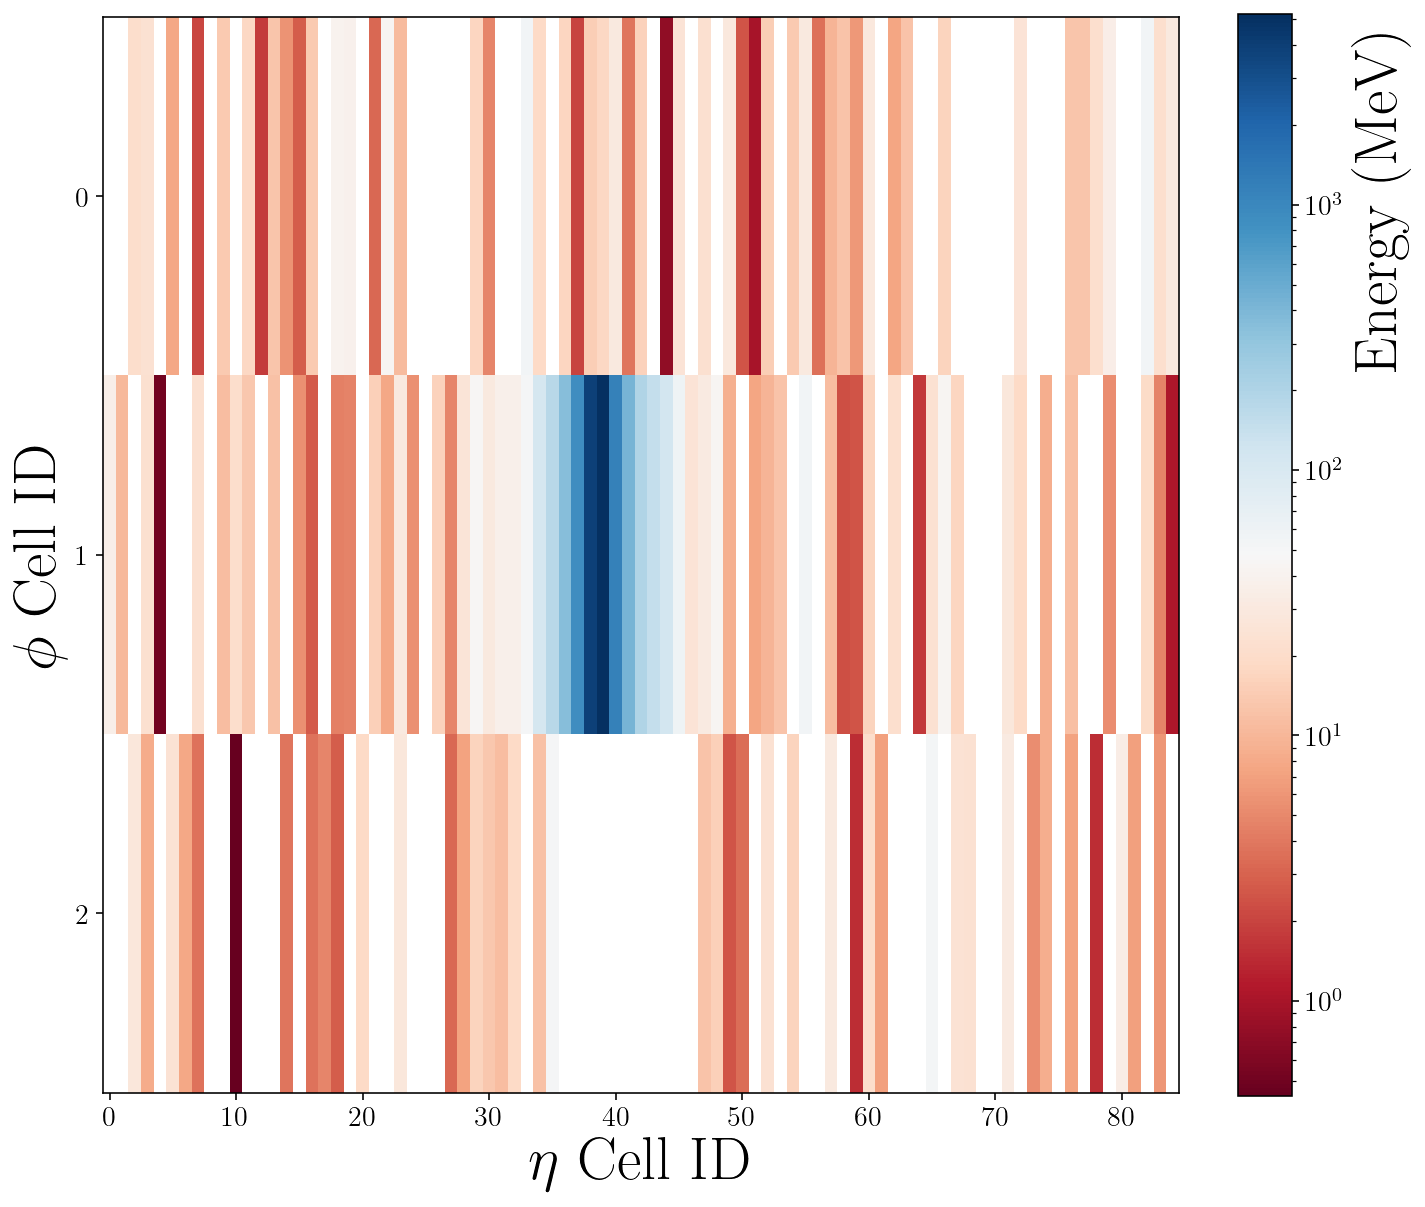

In [9]:
plot_image( data_electron['cells_em1'][4], 85, 3 , 'electron_em1_cells.pdf')

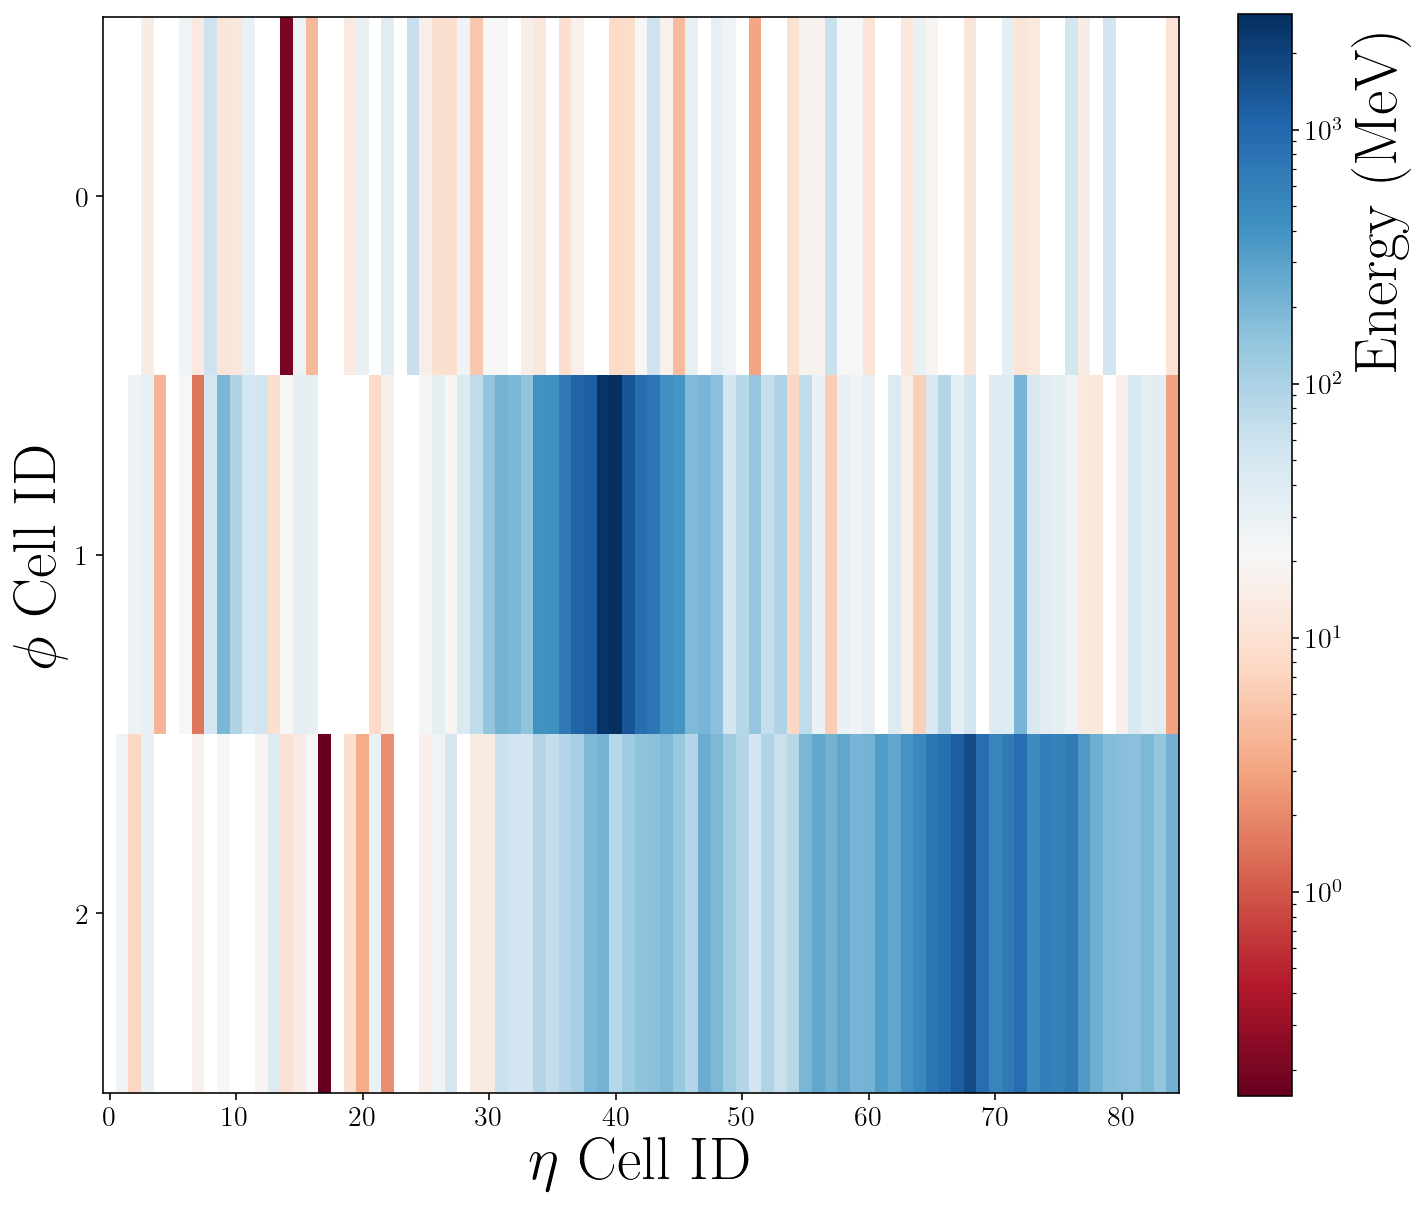

In [10]:
plot_image( data_jets['cells_em1'][0], 85, 3 , 'jets_em1_cells.pdf')

In [18]:
rings_electron = data_electron['data'][4, 9:73]
rings_jets = data_jets['data'][0, 9:73]
print(rings_jets.shape)

(64,)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


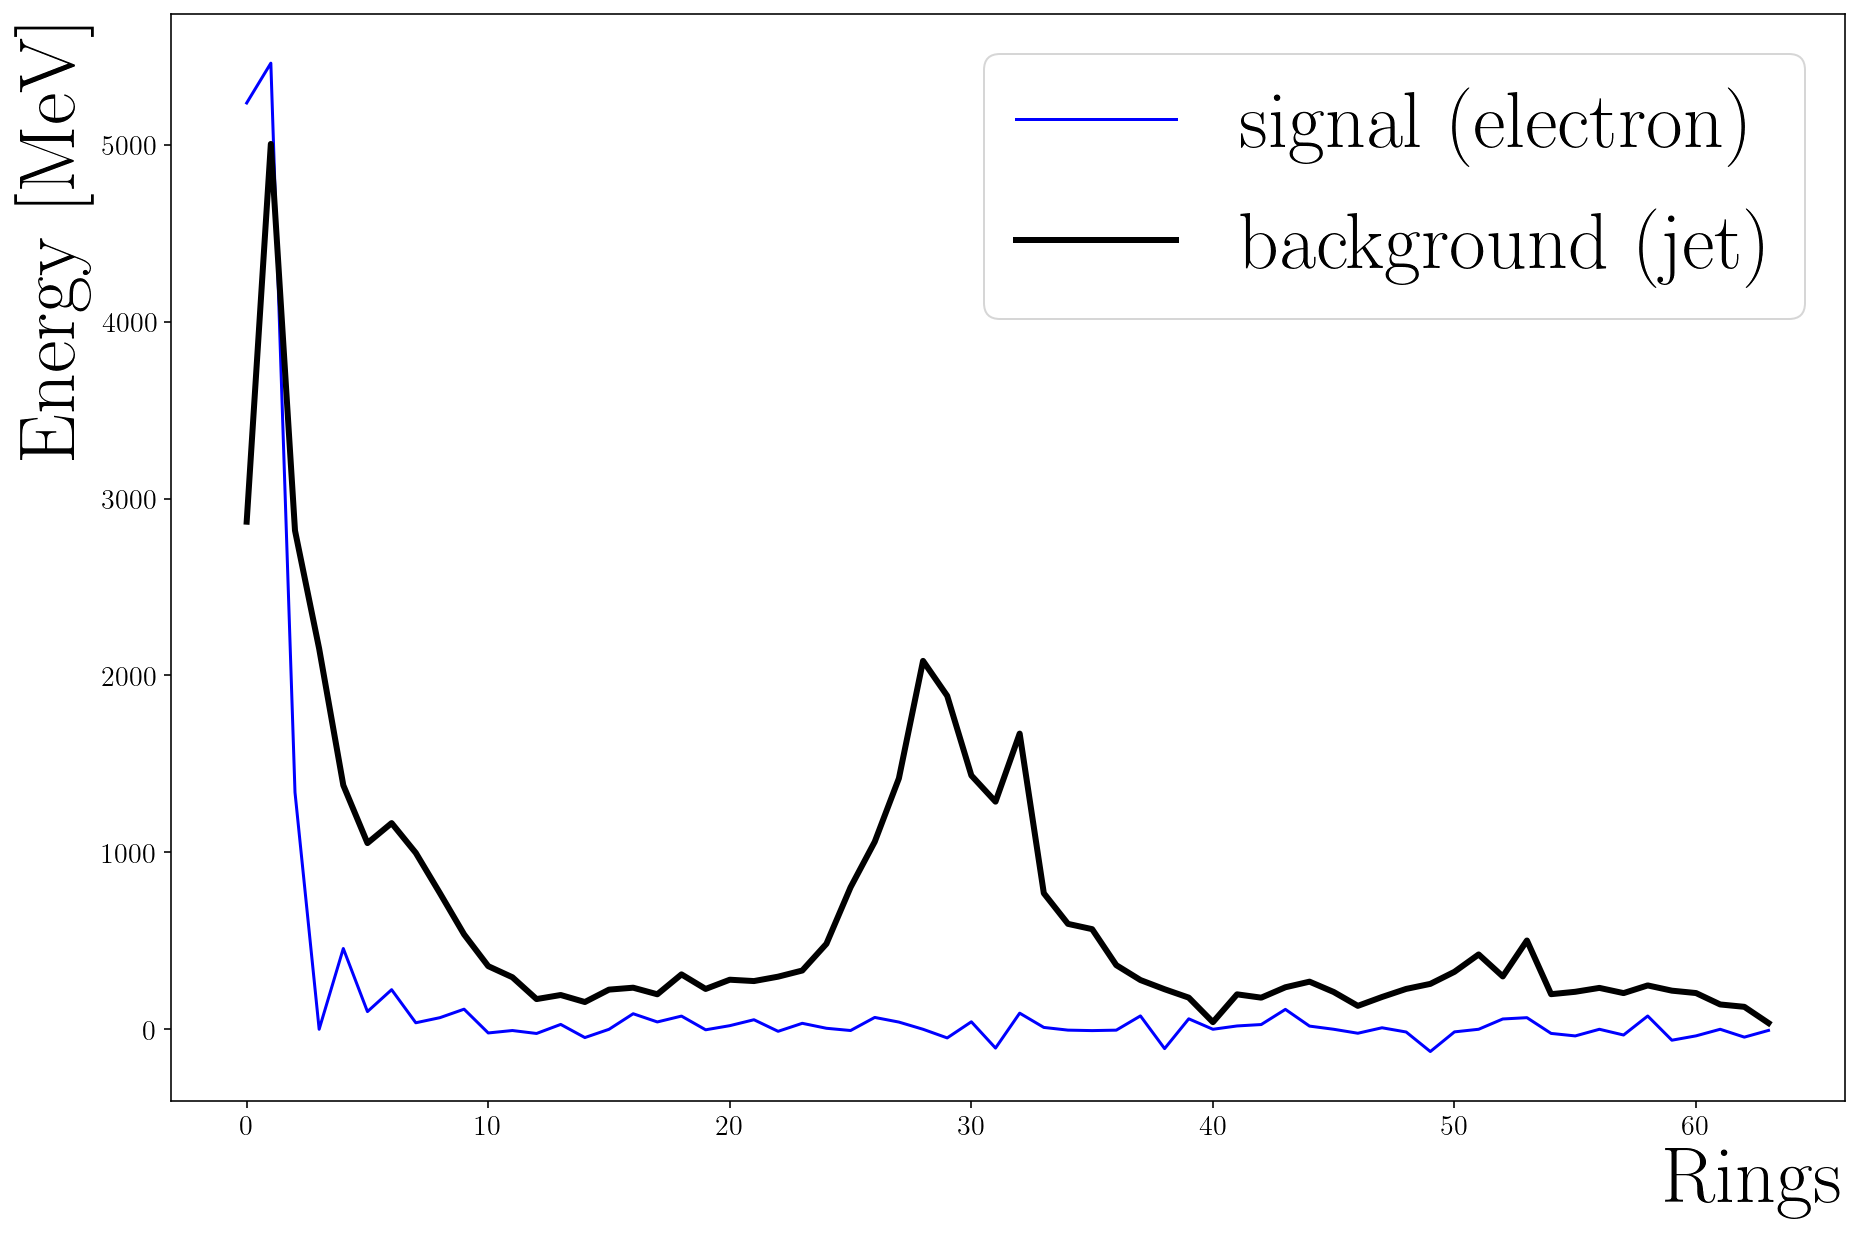

In [14]:
# Data for plotting
fig = plt.figure(figsize=(15,10))
plt.plot(list(range(64)), rings_electron, 'b')
plt.plot(list(range(64)), rings_jets, 'k', linewidth=3)
#plt.bar(list(range(64)), rings_jets,color = 'r', width = 0.95)
#plt.xlabel='Rings', ylabel='Energy [MeV]',
#       title='All rings from EM1 layer')
plt.xlabel('Rings',fontsize = 40,horizontalalignment='right', x=1)
plt.ylabel('Energy [MeV]',fontsize = 40,horizontalalignment='right', y=1.0)
plt.legend(['signal (electron)','background (jet)'],fontsize = 40)
plt.grid()
fig.savefig("rings.pdf")
plt.show()